Here I will compare the performance between the three different options for subject tokens : i) Full Name ii) Person PII iii) Full Name + Person PII

In [ ]:
### load results
import json

In [ ]:
def load_eval_results(eval_results_path, batch_size=None, grad_accum=None,method_name=None):
    with open(eval_results_path, 'r') as file:
        eval_results = json.load(file)

    exact_retain_score, retain_original = get_exact_retain(eval_results)
    exact_forget_score, forget_original = get_exact_forget(eval_results)

    return {
        'method' : method_name,
        'agg_retain_score': exact_retain_score,
        'retain_original': retain_original,
        'agg_forget_score': exact_forget_score,
        'forget_original': forget_original,
        'batch_size': batch_size,
        'grad_accum': grad_accum
    }

def get_exact_retain(eval_results):
    exact = eval_results["eval_log_retain.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase1 = eval_results["eval_log_retain_paraphrase_1.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase2 = eval_results["eval_log_retain_paraphrase_2.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase3 = eval_results["eval_log_retain_paraphrase_3.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase4 = eval_results["eval_log_retain_paraphrase_4.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase5 = eval_results["eval_log_retain_paraphrase_5.json"]["avg_pii_autocompletion_exact_leakage_score"]

    mean_exact = (exact + paraphrase1 + paraphrase2 + paraphrase3 + paraphrase4 + paraphrase5) / 6.0
    return mean_exact, exact

def get_exact_forget(eval_results):
    exact = eval_results["eval_log_forget.json"]["avg_pii_autocompletion_exact_leakage_score"]
    
    # Try to get paraphrased forget examples (if available)
    paraphrase_scores = []
    for i in range(1, 6):
        key = f"eval_log_forget_paraphrase_{i}.json"
        if key in eval_results:
            paraphrase_scores.append(eval_results[key]["avg_pii_autocompletion_exact_leakage_score"])
    
    # If paraphrases exist, calculate mean; otherwise use original
    if paraphrase_scores:
        mean_exact = (exact + sum(paraphrase_scores)) / (len(paraphrase_scores) + 1)
    else:
        mean_exact = exact
    
    return mean_exact, exact

In [14]:
path1 = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_SubjectKeyCompare_llama2-7b_E8_B16_G4_SKsubject/eval_results/eval_log_aggregated.json'
path2 = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_SubjectKeyCompare_llama2-7b_E8_B16_G4_SKsubject_pii/eval_results/eval_log_aggregated.json'
path3 = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_SubjectKeyCompare_llama2-7b_E8_B16_G4_SKsubject_person_pii/eval_results/eval_log_aggregated.json'
res1 = load_eval_results(path1, batch_size=16, grad_accum=4,method_name='full_name')
res2 = load_eval_results(path2, batch_size=16, grad_accum=4, method_name='pii')
res3 = load_eval_results(path3, batch_size=16, grad_accum=4, method_name='person_pii')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create DataFrame from your results
results = [res1, res2, res3]
df = pd.DataFrame(results)

#### Compare the performance of these diffferent subject_keys

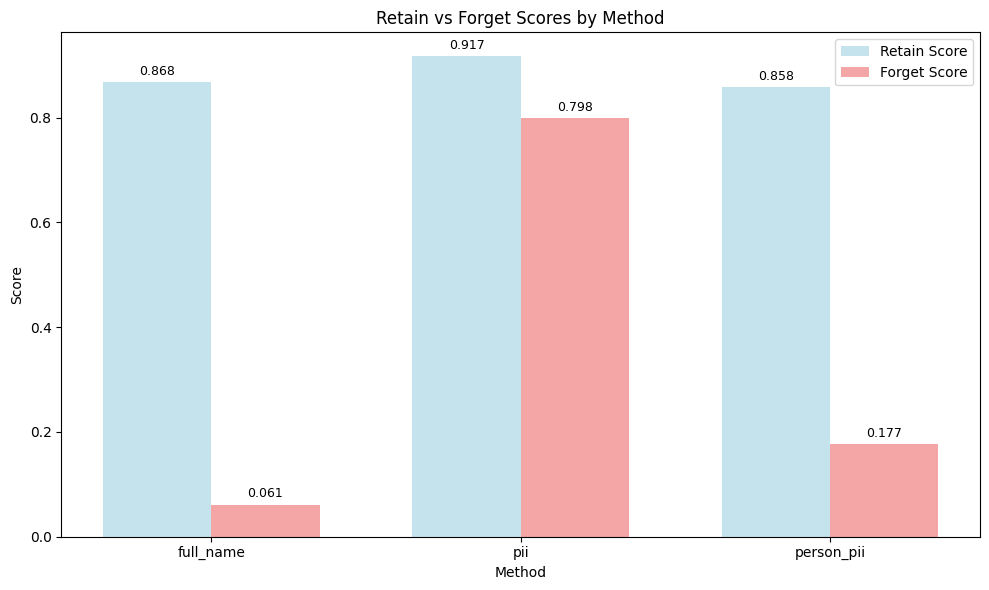


Summary:
Best Retain Score: pii (0.917)
Best Forget Score (lowest): full_name (0.061)


In [ ]:

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df['method']))
width = 0.35

bars1 = ax.bar(x - width/2, df['agg_retain_score'], width, label='Retain Score', color='lightblue', alpha=0.7)
bars2 = ax.bar(x + width/2, df['agg_forget_score'], width, label='Forget Score', color='lightcoral', alpha=0.7)

ax.set_xlabel('Method')
ax.set_ylabel('Score')
ax.set_title('Retain vs Forget Scores by Method')
ax.set_xticks(x)
ax.set_xticklabels(df['method'])
ax.legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary:")
print(f"Best Retain Score: {df.loc[df['agg_retain_score'].idxmax(), 'method']} ({df['agg_retain_score'].max():.3f})")
print(f"Best Forget Score (lowest): {df.loc[df['agg_forget_score'].idxmin(), 'method']} ({df['agg_forget_score'].min():.3f})")

We can clearly see that including pii separately results in very weak forgetting, and inlcuding both PII and Subject also results in weaker (but much better) unlearning


- It is surpising to me that including both subjects results in weaker unlearning than just full_name. This means that, whilst we add less noise to our exameples, we forget more. Of course, the relationship is not stupidly linear, as it is very important to realize the contrastive learning element of this. The idea of PerMU is to isolate the central fact of the sample, as the corrupted run results in a logit that are more grammar based rather than fact-related, and then subtracting corrupt_run_logits - clean_run_logits, thus subtracting the fact-related information, and giving room to tokens that are more based on grammar structure (in our case it will almost def halucinate other PII). However, when we add noise to both subject and PII, then the unlearning effect can become more washed out (not as strong for particular facts), and so the subtraction does not result in the same unlearning effect. We can probably confirm this by calculating the entropy of the last layer logits for the corrupt run, the person_pii subject key will almost definetely have less entropy.

- Interestingly, the retain score does not suffers least for the PII category, it must have something to do with there not being to much difference between the corrupt_logits and clean_logits when doing the contrastive bit, since the information of the PII is not the central/subject token of the method, the obvious one of course being the person itself. Similarly, the person is a stronger 'concept' than that number, since it has dozens of trianing samples with their names into it, so having entropy on the corrupt logits is definetely more guaranteed.


NOTE: I really want to do the entropy study, that would be so cool.


### Diference in time, subject/tokens processed between the 3 categories of Subject:


- full_name: 

        [2025-06-03 21:44:18,707][permu_stats][INFO] - PERFORMANCE STATISTICS
        [2025-06-03 21:44:18,707][permu_stats][INFO] - Runs: 1200
        [2025-06-03 21:44:18,708][permu_stats][INFO] - Avg time: 0.3396s (std: 0.1337)
        [2025-06-03 21:44:18,708][permu_stats][INFO] - Avg tokens: 7.19 (std: 2.84)
        [2025-06-03 21:44:18,709][permu_stats][INFO] - Avg subjects: 1.00 (std: 0.00)
        [2025-06-03 21:44:18,709][permu_stats][INFO] - Avg subject length: 6.50 (std: 1.53)
        [2025-06-03 21:44:18,709][permu_stats][INFO] - ==================================================


- pii: 

        [2025-06-03 22:54:24,803][permu_stats][INFO] - PERFORMANCE STATISTICS
        [2025-06-03 22:54:24,804][permu_stats][INFO] - Runs: 1200
        [2025-06-03 22:54:24,804][permu_stats][INFO] - Avg time: 2.1624s (std: 2.1039)
        [2025-06-03 22:54:24,805][permu_stats][INFO] - Avg tokens: 13.76 (std: 9.04)
        [2025-06-03 22:54:24,805][permu_stats][INFO] - Avg subjects: 1.38 (std: 0.60)
        [2025-06-03 22:54:24,806][permu_stats][INFO] - Avg subject length: 10.07 (std: 5.29)
        [2025-06-03 22:54:24,806][permu_stats][INFO] - ==================================================

- full_name + pii:

        [2025-06-04 00:16:25,977][permu_stats][INFO] - PERFORMANCE STATISTICS
        [2025-06-04 00:16:25,978][permu_stats][INFO] - Runs: 1200
        [2025-06-04 00:16:25,978][permu_stats][INFO] - Avg time: 2.4836s (std: 2.1293)
        [2025-06-04 00:16:25,979][permu_stats][INFO] - Avg tokens: 20.95 (std: 9.84)
        [2025-06-04 00:16:25,979][permu_stats][INFO] - Avg subjects: 2.38 (std: 0.60)
        [2025-06-04 00:16:25,980][permu_stats][INFO] - Avg subject length: 8.57 (std: 4.51)
        [2025-06-04 00:16:25,980][permu_stats][INFO] - ==================================================



As we can see, on avg creating a perturbed example is at least 7x faster, additionally it is also much more predictable. There are multiple reasons why that is the case:

1. Obviously, we simply have more subjects in the data for both the PII and the combined examples ( as we can have multiple PII per examples), more subjects -> more tokens to process -> more time
2. We can also see that the Avg to process is much higher, also with a much higher std for the PII examples. A lot of the PII have numbers in them, so tokenization would separate them and thus produce more tokens. Additionally, fact that some PII have numbers and others do not also explain the high std.

Analysis on Corrupt Layer Entropy : Subject Keys

In [ ]:
import re
import numpy as np
from collections import defaultdict

def process_entropy_logs(log_file_path):
    """
    Process PerMU entropy logs and calculate averages for different entropy types.
    
    Args:
        log_file_path (str): Path to the log file
        
    Returns:
        dict: Dictionary containing averaged entropy statistics
    """
    
    # Lists to store entropy values
    answer_entropies_mean = []
    answer_entropies_std = []
    subject_entropies_all = []
    overall_entropies = []
    
    # Read the log file
    with open(log_file_path, 'r') as f:
        lines = f.readlines()
    
    # Process each line
    for line in lines:
        line = line.strip()
        
        # Extract answer tokens entropy
        if "Answer tokens entropy - Mean:" in line:
            # Pattern: Answer tokens entropy - Mean: 0.7318, Std: 1.1160
            match = re.search(r'Answer tokens entropy - Mean: ([\d.]+), Std: ([\d.]+)', line)
            if match:
                mean_val = float(match.group(1))
                std_val = float(match.group(2))
                answer_entropies_mean.append(mean_val)
                answer_entropies_std.append(std_val)
        
        # Extract subject tokens entropy
        elif "Subject tokens entropy - Values:" in line:
            # Pattern: Subject tokens entropy - Values: ['3.1184', '2.3773']
            match = re.search(r"Subject tokens entropy - Values: \[(.*?)\]", line)
            if match:
                values_str = match.group(1)
                # Extract individual values
                values = re.findall(r"'([\d.]+)'", values_str)
                for val in values:
                    subject_entropies_all.append(float(val))
        
        # Extract overall sequence entropy
        elif "Overall sequence entropy - Mean:" in line:
            # Pattern: Overall sequence entropy - Mean: 1.8354
            match = re.search(r'Overall sequence entropy - Mean: ([\d.]+)', line)
            if match:
                overall_val = float(match.group(1))
                overall_entropies.append(overall_val)
    
    # Calculate statistics
    results = {
        'answer_tokens': {
            'mean_entropy_avg': np.mean(answer_entropies_mean) if answer_entropies_mean else 0,
            'mean_entropy_std': np.std(answer_entropies_mean) if answer_entropies_mean else 0,
            'std_entropy_avg': np.mean(answer_entropies_std) if answer_entropies_std else 0,
            'count': len(answer_entropies_mean)
        },
        'subject_tokens': {
            'entropy_avg': np.mean(subject_entropies_all) if subject_entropies_all else 0,
            'entropy_std': np.std(subject_entropies_all) if subject_entropies_all else 0,
            'count': len(subject_entropies_all)
        },
        'overall_sequence': {
            'entropy_avg': np.mean(overall_entropies) if overall_entropies else 0,
            'entropy_std': np.std(overall_entropies) if overall_entropies else 0,
            'count': len(overall_entropies)
        }
    }
    
    return results

def print_entropy_summary(results):
    """Print a compact summary of entropy statistics."""
    
    print("=" * 50)
    print("PERMU ENTROPY SUMMARY")
    print("=" * 50)
    answer_avg = results['answer_tokens']['mean_entropy_avg']
    subject_avg = results['subject_tokens']['entropy_avg']
    overall_avg = results['overall_sequence']['entropy_avg']
    
    print(f"Answer Tokens:  {answer_avg:.4f} ± {results['answer_tokens']['mean_entropy_std']:.4f} (n={results['answer_tokens']['count']})")
    print(f"Subject Tokens: {subject_avg:.4f} ± {results['subject_tokens']['entropy_std']:.4f} (n={results['subject_tokens']['count']})")
    print(f"Overall Seq:    {overall_avg:.4f} ± {results['overall_sequence']['entropy_std']:.4f} (n={results['overall_sequence']['count']})")
    
    print("=" * 50)

In [32]:
full_name_log_file_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/FullFT_PII_llama2-7b_E3_B16_intextTrue_replaceprob1_token_k_neighbours2_subject_key_subject_entropylogging/hydra_logs/PerMU/2025-06-04/13-05-45/PerMU_llama2-7b_B16_G1.log"  # Replace with your actual log file path
results = process_entropy_logs(full_name_log_file_path)
print("Entropy Statistics SubjectKey = FullName:")
print_entropy_summary(results)

Entropy Statistics SubjectKey = FullName:
PERMU ENTROPY SUMMARY
Answer Tokens:  2.6829 ± 1.5162 (n=576)
Subject Tokens: 4.6966 ± 1.6672 (n=1152)
Overall Seq:    0.6502 ± 0.4562 (n=576)


In [ ]:
full_name_log_file_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/FullFT_PII_llama2-7b_E3_B16_intextTrue_replaceprob1_token_k_neighbours2_subject_key_subject_pii_entropylogging/hydra_logs/PerMU/2025-06-04/13-25-12/PerMU_llama2-7b_B16_G1.log"
results = process_entropy_logs(full_name_log_file_path)
print("Entropy Statistics SubjectKey = PII:")
print_entropy_summary(results)

Entropy Statistics SubjectKey = Subject PII:
PERMU ENTROPY SUMMARY
Answer Tokens:  1.5754 ± 0.7717 (n=576)
Subject Tokens: 3.0011 ± 1.2273 (n=793)
Overall Seq:    0.3817 ± 0.2785 (n=576)


In [47]:
full_name_log_file_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/FullFT_PII_llama2-7b_E3_B16_intextTrue_replaceprob1_token_k_neighbours2_subject_key_subject_person_pii_entropylogging/hydra_logs/PerMU/2025-06-04/13-58-35/PerMU_llama2-7b_B16_G1.log"
results = process_entropy_logs(full_name_log_file_path)
print("Entropy Statistics SubjectKey = PII+FullName:")
print_entropy_summary(results)

Entropy Statistics SubjectKey = PII+FullName:
PERMU ENTROPY SUMMARY
Answer Tokens:  3.7436 ± 1.5115 (n=544)
Subject Tokens: 4.5348 ± 1.5727 (n=1838)
Overall Seq:    0.6128 ± 0.3612 (n=544)



#### Why The FullName option is better than the PII option: 

The Ideal PerMU behaviour would have low entropy for the clean run logits, and high entropy for the corrupted logits. Since, the corrupted run is supposed to leave the model more confused (i.e aware unaware of fact-related info, so it follows only structure, this exactly means that the model is confused). So, looking at our examples here, we see that the example with Subject PII has lower entropy, meaning that the model is not as confused. If the Corrupt example makes the model less confused, then constrastive learning does not happen as it should, as the best unlearnig (in terms of forget metrics) happens when the difference is large, creating a strong unlearning signal. -> This explains why the model does not forget well with the PII as subject. 


Now, as to why we get high-entropy for full_name and low-entropy for PII:

- the full_name is a more concrete concept, we have a couple dozen training examples per full name
- the full_name is present both in the question and in the answer, making it a more central concept for the individual sample.
- a full_name is observed as a primary jey for fact retrieval for a model's learned representation, full names were pretty much always selected as subject tokens in PerMU's original MSM.

#### Why the FullName+PII option exhibited worse forgetting results :


The combination option has much higher confusion when it comes to the answer tokens, and comparable confusion for the overall sequnce and the subject tokens. The effect on the retain set is comparable to the FullName, but the forget set shows much worse performacne (0.06 to 0.17). This is somehwat surpririsng, as I expected in this case to maybe have an even stronger unlearnign signal ( resulting in lower retain and lower forget). 


Possible Explanation: Perhaps the loss-landscape becomes to chaotic with this overly corrupted noise, making it difficult for GD to minimize the forget_loss part of our loss funciton, while the retain part is solid and thus we maintain same retain for FullName and FullName+PII